<a href="https://colab.research.google.com/github/emilydolson/alife-phylogeny-tutorial/blob/main/perfect_tracking_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

We need to start out by installing some python packages

In [2]:
# !find . -name . -o -prune -exec rm -rf -- {} +
!git init
!git remote add origin https://github.com/emilydolson/alife-phylogeny-tutorial.git
!git pull origin main
!python3 -m pip install -r requirements.txt

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 139 (delta 57), reused 72 (delta 20), pack-reused 0
Receiving objects: 100% (139/139), 126.99 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (57/57), done.
From https://github.com/emilydolson/alife-phylogeny-tutorial
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
 

# Tracking Phylogenies in DEAP

[DEAP](https://deap.readthedocs.io) is a popular Python library for evolutionary computation, which has simple built-in phylogeny tracking via the [deap.tools.History](https://deap.readthedocs.io/en/master/api/tools.html#history) class. It tracks phylogenies at the individual level and can handle recombination. However, because it does not handle more abstract taxon representations or pruning, it can use a lot of memory.

For example, let's consider the simple [onemax example in DEAP](https://github.com/DEAP/deap/blob/3f8f09fc7248e7adbb28aeafc97cf81dbaa226bd/examples/ga/onemax.py). We could add phylogeny tracking by doing the following:

In [14]:
import random

from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator:
#   define 'attr_bool' to be an attribute ('gene')
#   which corresponds to integers sampled uniformly
#   from the range [0,1] (i.e. 0 or 1 with equal
#   probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers:
#   define 'individual' to be an individual
#   consisting of 100 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual,
    toolbox.attr_bool, 100)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# the goal ('fitness') function to be maximized
def evalOneMax(individual):
    return sum(individual),

#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", evalOneMax)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selTournament, tournsize=3)

#----------

#----------
# Phylogeny set-up
#----------

# Create the "History" object, which will hold the phylogeny
history = tools.History()

# Decorate the variation operators so that each time a new
# individual is created, `history` gets notified and can
# record the event correctly
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)


def evolve():
    random.seed(64)

    # create an initial population of 300 individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=5)

    # Notify phylogeny of initial population members
    history.update(pop)

    # CXPB  is the probability with which two individuals
    #       are crossed
    #
    # MUTPB is the probability for mutating an individual
    CXPB, MUTPB = 0.5, 0.2

    print("Start of evolution")

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0

    # Begin the evolution
    while max(fits) < 100 and g < 10:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)

        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print("  Evaluated %i individuals" % len(invalid_ind))

        # The population is entirely replaced by the offspring
        pop[:] = offspring


    print("-- End of (successful) evolution --")

    return history.genealogy_tree

phylogeny = evolve()

Start of evolution
  Evaluated 5 individuals
-- Generation 1 --
  Evaluated 3 individuals
-- Generation 2 --
  Evaluated 0 individuals
-- Generation 3 --
  Evaluated 3 individuals
-- Generation 4 --
  Evaluated 2 individuals
-- Generation 5 --
  Evaluated 3 individuals
-- Generation 6 --
  Evaluated 4 individuals
-- Generation 7 --
  Evaluated 2 individuals
-- Generation 8 --
  Evaluated 3 individuals
-- Generation 9 --
  Evaluated 3 individuals
-- Generation 10 --
  Evaluated 3 individuals
-- End of (successful) evolution --


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


We can make a simple plot of this phylogeny using networkx

<ipython-input-18-82b33e93b3b4>:8: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


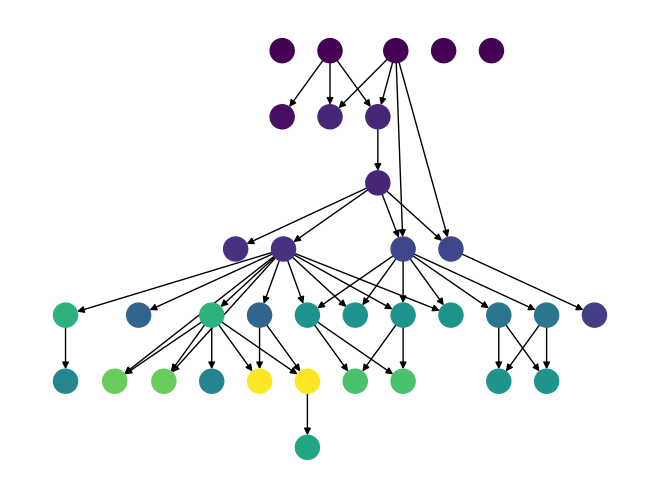

In [18]:
import matplotlib.pyplot as plt
import networkx
from networkx.drawing.nx_pydot import graphviz_layout

graph = networkx.DiGraph(phylogeny)
graph = graph.reverse()     # Make the graph top-down
colors = [toolbox.evaluate(phylogeny[i])[0] for i in graph]
pos = graphviz_layout(graph, prog="dot")
networkx.draw(graph, node_color=colors, pos=pos)
plt.show()

To do more elaborate phylogenetic analysis, we will probably need to put it into a mmore standardized format.

In [23]:
with open("deap_phylogeny.csv", "w") as outfile:
  outfile.write("id, ancestor_list\n")
  for tax in phylogeny:
    anc_list = list(phylogeny[tax])
    if not anc_list:
      anc_list = [None]
    outfile.write(",".join([str(tax), str(anc_list)]) + "\n")

In [24]:
!cat deap_phylogeny.csv

id, ancestor_list
1,[None]
2,[None]
3,[None]
4,[None]
5,[None]
6,[4, 2]
7,[4, 2]
8,[6]
9,[2]
10,[8, 4]
11,[8, 4]
12,[8]
13,[10]
14,[11, 11]
15,[11, 11]
16,[14, 15]
17,[14, 15]
18,[8]
19,[18, 11]
20,[18, 11]
21,[18, 11]
22,[18, 11]
23,[19, 21]
24,[19, 21]
25,[18, 18]
26,[18, 18]
27,[26]
28,[18]
29,[18, 25]
30,[18, 25]
31,[18]
32,[25, 31]
33,[25, 31]
34,[33]
35,[25]


# Phylotrackpy

Let's start out by making a simply systematics manager and adding a few taxa to it. We'll imagine this is a world where we're evolving strings, and we want each unique string to be its own taxon (i.e. node in the phylogeny).

In [7]:
import phylotrackpy.systematics as phylo

# Make a systematics manager object
# The information that determines the taxa is literally just the organism,
# so we pass the constructor a simple lambda that returns whatever it is given
# The Trues and Falses say it should keep track of extant taxa and their ancestors
# but not taxa from extinct lineages (i.e. it should do pruning)
# Also, it will not store positions, so the user is responsible for keeping
# track of pointers to taxa.
example_sys = phylo.Systematics(lambda x: x, store_pos=False)

# The systematics manager starts out empty
print(example_sys.get_num_taxa())

0


Now let's try manually adding some organisms

In [8]:
# Add an organism that is the string "hello"
taxon1 = example_sys.add_org("hello")
# Now the systematics manager has a taxon in it
print("Number of taxa after adding org 1:", example_sys.get_num_taxa())

# Tell example_sys that taxon1 gave birth to the string "world"
taxon2 = example_sys.add_org("world", taxon1)
# Now the systematics manager has 2 taxa in it
print("Number of taxa after adding org 2:", example_sys.get_num_taxa())

# Tell example_sys that taxon2 gave birth to an organism identical to itself
taxon3 = example_sys.add_org("world", taxon2)
# The systematics manager still has 2 taxa in it, because this new org
# was added to the same taxon
print("Number of taxa after adding org 2:", example_sys.get_num_taxa())
print("Number of individuals in taxon 2: ", taxon2.get_num_orgs())

# NOTE: taxon2 and taxon3 are pointers to the same object!
# We can confirm this by printing their IDs
print("taxon2 ID:", taxon2.get_id())
print("taxon3 ID:", taxon3.get_id())

# Let's make two more taxa
taxon4 = example_sys.add_org("jello", taxon1)
taxon5 = example_sys.add_org("jelly", taxon4)
print("Number of taxa after adding org 5:", example_sys.get_num_taxa())


Number of taxa after adding org 1: 1
Number of taxa after adding org 2: 2
Number of taxa after adding org 2: 2
Number of individuals in taxon 2:  2
taxon2 ID: 2
taxon3 ID: 2
Number of taxa after adding org 5: 4


The phylogeny now looks like this:

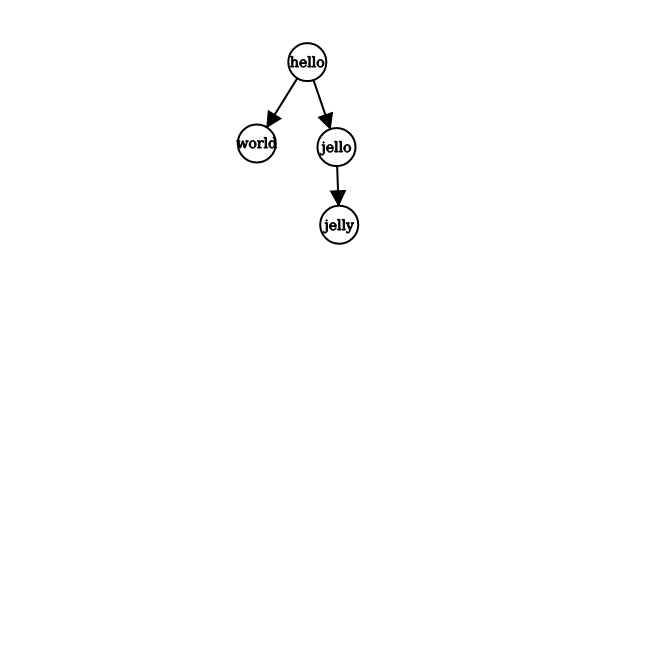

What hapens if we try deleting organisms?

In [9]:
example_sys.remove_org(taxon4)

# The "jello" taxon is now gone
print("Number of taxa after removing jello:", example_sys.get_num_taxa())
# Why is it still 4 taxa? Because jello had an offspring taxon (jelly), so its
# still included in the phylogeny as an ancestor
# We can see this if we count the active and ancestor taxa separately
print("Number of active taxa after removing jello:", example_sys.get_num_active())
print("Number of ancestor taxa after removing jello", example_sys.get_num_ancestors())

# Removing one org from taxon2 won't make that taxon extinct, because
# there are two of them
example_sys.remove_org(taxon2)
# There are still 4 taxa
print("Number of taxa after removing world once:", example_sys.get_num_taxa())
# taxon2 now only has one org, though
print("Number of orgs in taxon2:", taxon2.get_num_orgs())

# Lets try removing jelly too
example_sys.remove_org(taxon5)
# Now there are only 2 taxa in the tree, because the jello -> jelly lineage was
# pruned out due to being extinct
print("Number of taxa after removing jelly:", example_sys.get_num_taxa())

Number of taxa after removing jello: 4
Number of active taxa after removing jello: 3
Number of ancestor taxa after removing jello 1
Number of taxa after removing world once: 4
Number of orgs in taxon2: 1
Number of taxa after removing jelly: 2


# Incorporating phylotrackpy into existing code

Phylotrackpy is designed to easily plug in to existing codebases. Let's return to the DEAP example from before. Imagine that we want to use Phylotrackpy instead of the built in History class (perhaps we aren't using crossover and need to use pruning). How would we need to change our code to make that work?

Note: I suspect the DEAP-style way to do this would be to use decorators like the History class does. For simplicity, here we will do it the longer and slightly more straighforward way.

In [10]:
import random

from deap import base
from deap import creator
from deap import tools

import phylotrackpy.systematics as phylo

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator:
#   define 'attr_bool' to be an attribute ('gene')
#   which corresponds to integers sampled uniformly
#   from the range [0,1] (i.e. 0 or 1 with equal
#   probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers:
#   define 'individual' to be an individual
#   consisting of 100 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual,
    toolbox.attr_bool, 10)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# the goal ('fitness') function to be maximized
def evalOneMax(individual):
    return sum(individual),

#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", evalOneMax)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selTournament, tournsize=3)

#----------

#----------
# Phylogeny set-up
#----------

sys = phylo.Systematics(lambda x: str(x), True, True, False, False)
sys.add_snapshot_fun(lambda tax: str(tax.get_info()).replace(",",""), "Genome", "The taxon's genome")

def evolve():
    random.seed(64)

    # create an initial population of 300 individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=5)

    sys.set_update(0)

    # Notify phylogeny of initial population members
    for ind in pop:
      tax = sys.add_org(ind)
      ind.taxon = tax

    # MUTPB is the probability for mutating an individual
    MUTPB = 0.5

    print("Start of evolution")

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0

    # Begin the evolution
    while max(fits) < 100 and g < 100:

        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)

        sys.set_update(g)

        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        for mutant in offspring:

            # mutate an individual with probability MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

            mutant.taxon = sys.add_org(mutant, mutant.taxon)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        for ind in pop:
          sys.remove_org(ind.taxon)

        print("  Evaluated %i individuals" % len(invalid_ind))

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        sys.snapshot(f"snapshot_{g}.csv")


    print("-- End of (successful) evolution --")
    sys.snapshot("final_snapshot.csv")


evolve()

Start of evolution
  Evaluated 5 individuals
-- Generation 1 --
  Evaluated 2 individuals
-- Generation 2 --
  Evaluated 3 individuals
-- Generation 3 --
  Evaluated 4 individuals
-- Generation 4 --
  Evaluated 4 individuals
-- Generation 5 --
  Evaluated 3 individuals
-- Generation 6 --
  Evaluated 4 individuals
-- Generation 7 --
  Evaluated 3 individuals
-- Generation 8 --
  Evaluated 3 individuals
-- Generation 9 --
  Evaluated 1 individuals
-- Generation 10 --
  Evaluated 4 individuals
-- Generation 11 --
  Evaluated 2 individuals
-- Generation 12 --
  Evaluated 2 individuals
-- Generation 13 --
  Evaluated 2 individuals
-- Generation 14 --
  Evaluated 1 individuals
-- Generation 15 --
  Evaluated 2 individuals
-- Generation 16 --
  Evaluated 2 individuals
-- Generation 17 --
  Evaluated 2 individuals
-- Generation 18 --
  Evaluated 2 individuals
-- Generation 19 --
  Evaluated 0 individuals
-- Generation 20 --
  Evaluated 3 individuals
-- Generation 21 --
  Evaluated 3 individual

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [11]:
!cat final_snapshot.csv

id,ancestor_list,origin_time,destruction_time,num_orgs,tot_orgs,num_offspring,total_offspring,depth,Genome
107,[35],100,inf,1,1,0,0,4,[1 1 1 1 0 1 0 1 1 1]
106,[35],100,inf,1,1,0,0,4,[1 1 1 1 1 1 0 1 1 1]
35,[14],33,inf,3,249,2,2,3,[1 1 1 1 1 1 1 1 1 1]
14,[9],6,36,0,104,1,3,2,[1 1 1 1 1 1 0 1 1 1]
9,[4],4,8,0,5,1,3,1,[1 1 1 1 1 0 0 1 0 1]
4,["NONE"],0,5,0,8,1,3,0,[1 1 1 1 1 0 0 0 0 1]


# Data visualization

Now that we have some phylogenies, let's visualize them!

One way we might want to do that would be to leverage existing bioinformatics tools. In that casse, we would need to start by converting to a standard bioinformatics format (e.g. newick).

In [37]:
import alifedata_phyloinformatics_convert as apc
import pandas as pd

alife_df = pd.read_csv('final_snapshot.csv')
alife_df["ancestor_list"] = alife_df["ancestor_list"].apply(lambda x: "[None]" if x == '["NONE"]' else x)

# get a dendropy Tree from alife-standardized phylogeny pandas dataframe
dendropy_trees = apc.alife_dataframe_to_dendropy_trees(alife_df)
i = 0
for tree in dendropy_trees:
  print(tree)
  tree.write_to_path(f"final_{i}.nwk", "newick")
  i += 1



((((,))))


This has given us a tree that we can plug into pre-built visualizers, like [IcyTree](https://icytree.org/)